# UNet


## Install Dependencies

In [1]:
# !pip install torchinfo --quiet

## Import Dependencies

In [2]:
# Standard Library Imports
import os
import sys

# Third-Party Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchsummary import summary

# Local Imports
!git clone https://github.com/Shilpaj1994/ERA.git
sys.path.insert(0,'./ERA/Session18/')

from utils import tensor_trimap, args_to_dict, display_loss_and_accuracies, display_output
from dataset import OxfordIIITPetsAugmented
from model import UNet
from training_utils import train, test, dice_loss

Cloning into 'ERA'...
remote: Enumerating objects: 973, done.
remote: Counting objects: 100% (584/584), done.
remote: Compressing objects: 100% (503/503), done.
remote: Total 973 (delta 140), reused 518 (delta 76), pack-reused 389
Receiving objects: 100% (973/973), 62.29 MiB | 11.08 MiB/s, done.
Resolving deltas: 100% (299/299), done.


## Dataset Preparation

In [3]:
transform_dict = args_to_dict(
    pre_transform=transforms.ToTensor(),
    pre_target_transform=transforms.ToTensor(),

    common_transform=transforms.Compose([
        transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST),
    ]),

    post_transform=transforms.Compose([
        transforms.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=transforms.Compose([
        transforms.Lambda(tensor_trimap),
    ]),
)

In [4]:
train_dataset = OxfordIIITPetsAugmented(
    root='./data/OxfordPets/train',
    split="trainval",
    target_types="segmentation",
    download=True,
    **transform_dict,
)

test_dataset = OxfordIIITPetsAugmented(
    root='./data/OxfordPets/test',
    split="test",
    target_types="segmentation",
    download=True,
    **transform_dict,
)

100%|██████████| 791918971/791918971 [00:06<00:00, 114904843.40it/s]


Extracting data/OxfordPets/train/oxford-iiit-pet/images.tar.gz to data/OxfordPets/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 109643977.93it/s]


Extracting data/OxfordPets/train/oxford-iiit-pet/annotations.tar.gz to data/OxfordPets/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:06<00:00, 126402769.72it/s]


Extracting data/OxfordPets/test/oxford-iiit-pet/images.tar.gz to data/OxfordPets/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 105838549.84it/s]


Extracting data/OxfordPets/test/oxford-iiit-pet/annotations.tar.gz to data/OxfordPets/test/oxford-iiit-pet


## DataLoader Preparation

In [5]:
SEED = 8
BATCH_SIZE = 16

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=False, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Train DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

# Test DataLoader
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

CUDA Available? True


## Visualize Data

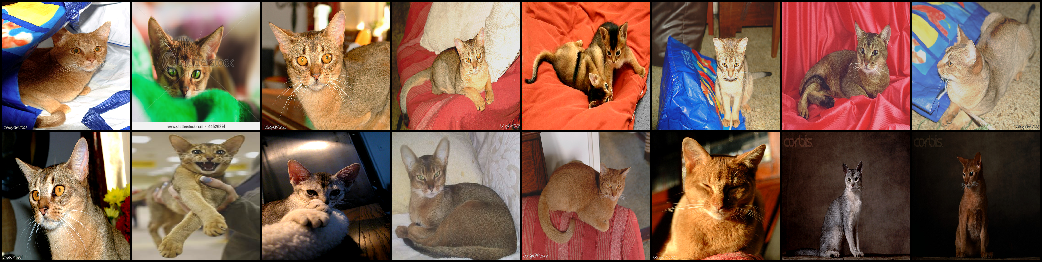

In [6]:
# Convert a pytorch tensor into a PIL image
t2img = transforms.ToPILImage()

train_pets_inputs, train_pets_targets = next(iter(train_loader))

pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

## Visualize Masks

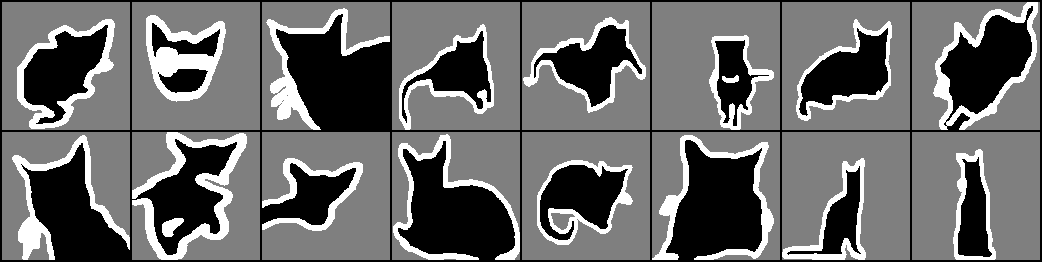

In [7]:
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8)
t2img(pets_targets_grid)

## Training Parameters

In [8]:
EPOCHS = 20
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-5

## Training Run

In [9]:
def train_session(model, loss):
    """
    Function to train the model
    """
    # Data to plot accuracy and loss graphs
    train_losses = []
    test_losses = []

    # Optimization algorithm to update the weights
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Scheduler to change the learning rate after specific number of epochs
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)
    scheduler = None

    # CE OR Dice Loss
    criterion = loss

    # For each epoch
    for epoch in range(1, EPOCHS+1):
        print(" ")
        print(f'Epoch {epoch}')

        # Train the model on training dataset and append the training loss and accuracy
        train_loss = train(model, device, train_loader, optimizer, criterion, scheduler)
        train_losses.append(train_loss / len(train_loader))

        # Test the model's performance on test dataset and append the training loss and accuracy
        test_loss = test(model, device, test_loader, criterion)
        test_losses.append(test_loss)

    display_loss_and_accuracies(train_losses, test_losses)

---

## 1. Model Training - MaxPool + Transpose + Cross Entropy Loss

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

Train: Loss=0.6291 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.32it/s]


Test set: Average loss: 0.7015
 
Epoch 2


Train: Loss=0.5507 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.40it/s]


Test set: Average loss: 0.6409
 
Epoch 3


Train: Loss=0.5615 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.36it/s]


Test set: Average loss: 0.6069
 
Epoch 4


Train: Loss=0.5457 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.35it/s]


Test set: Average loss: 0.5975
 
Epoch 5


Train: Loss=0.4888 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.45it/s]


Test set: Average loss: 0.5627
 
Epoch 6


Train: Loss=0.4847 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.44it/s]


Test set: Average loss: 0.5263
 
Epoch 7


Train: Loss=0.4454 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.45it/s]


Test set: Average loss: 0.5119
 
Epoch 8


Train: Loss=0.4098 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.45it/s]


Test set: Average loss: 0.4720
 
Epoch 9


Train: Loss=0.3805 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.36it/s]


Test set: Average loss: 0.4562
 
Epoch 10


Train: Loss=0.3701 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.28it/s]


Test set: Average loss: 0.4232
 
Epoch 11


Train: Loss=0.3629 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.43it/s]


Test set: Average loss: 0.4188
 
Epoch 12


Train: Loss=0.3346 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.42it/s]


Test set: Average loss: 0.3987
 
Epoch 13


Train: Loss=0.3263 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.22it/s]


Test set: Average loss: 0.4003
 
Epoch 14


Train: Loss=0.3333 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.45it/s]


Test set: Average loss: 0.3907
 
Epoch 15


Train: Loss=0.3041 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.45it/s]


Test set: Average loss: 0.3889
 
Epoch 16


Train: Loss=0.2920 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.46it/s]


Test set: Average loss: 0.3934
 
Epoch 17


Train: Loss=0.2773 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.37it/s]


Test set: Average loss: 0.3713
 
Epoch 18


Train: Loss=0.2633 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.41it/s]


Test set: Average loss: 0.3614
 
Epoch 19


Train: Loss=0.2657 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.25it/s]


Test set: Average loss: 0.3552
 
Epoch 20


Train: Loss=0.2287 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.39it/s]


Test set: Average loss: 0.3539


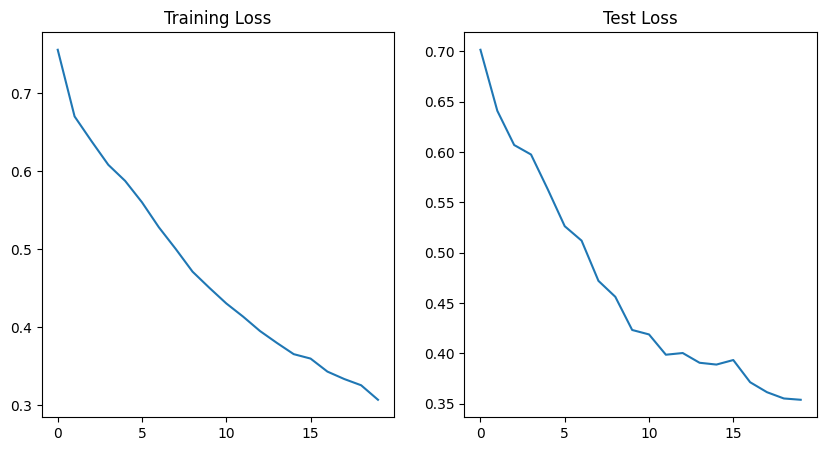

In [10]:
model = UNet(3, 3)
model = model.to('cuda')
summary(model, input_size=(3, 128, 128))

# CE Loss
criterion = nn.CrossEntropyLoss()

train_session(model, criterion)

---

## 2. Model Training - MaxPool + Transpose + Dice Loss

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

Train: Loss=0.4790 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.41it/s]


Test set: Average loss: 0.4576
 
Epoch 2


Train: Loss=0.4621 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.45it/s]


Test set: Average loss: 0.4246
 
Epoch 3


Train: Loss=0.4320 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.23it/s]


Test set: Average loss: 0.3772
 
Epoch 4


Train: Loss=0.4136 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.39it/s]


Test set: Average loss: 0.3624
 
Epoch 5


Train: Loss=0.3780 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.35it/s]


Test set: Average loss: 0.3346
 
Epoch 6


Train: Loss=0.3300 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.32it/s]


Test set: Average loss: 0.3423
 
Epoch 7


Train: Loss=0.3478 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.43it/s]


Test set: Average loss: 0.3198
 
Epoch 8


Train: Loss=0.3204 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.47it/s]


Test set: Average loss: 0.3259
 
Epoch 9


Train: Loss=0.3007 Batch_id=229: 100%|██████████| 230/230 [00:41<00:00,  5.48it/s]


Test set: Average loss: 0.3096
 
Epoch 10


Train: Loss=0.2833 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.44it/s]


Test set: Average loss: 0.2792
 
Epoch 11


Train: Loss=0.3083 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.36it/s]


Test set: Average loss: 0.2669
 
Epoch 12


Train: Loss=0.3002 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.31it/s]


Test set: Average loss: 0.2664
 
Epoch 13


Train: Loss=0.2846 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.36it/s]


Test set: Average loss: 0.2563
 
Epoch 14


Train: Loss=0.2708 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.39it/s]


Test set: Average loss: 0.2597
 
Epoch 15


Train: Loss=0.2937 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.42it/s]


Test set: Average loss: 0.2568
 
Epoch 16


Train: Loss=0.2723 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.42it/s]


Test set: Average loss: 0.2469
 
Epoch 17


Train: Loss=0.2582 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.38it/s]


Test set: Average loss: 0.2554
 
Epoch 18


Train: Loss=0.2791 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.35it/s]


Test set: Average loss: 0.2449
 
Epoch 19


Train: Loss=0.2518 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.31it/s]


Test set: Average loss: 0.2522
 
Epoch 20


Train: Loss=0.2687 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.44it/s]


Test set: Average loss: 0.2315


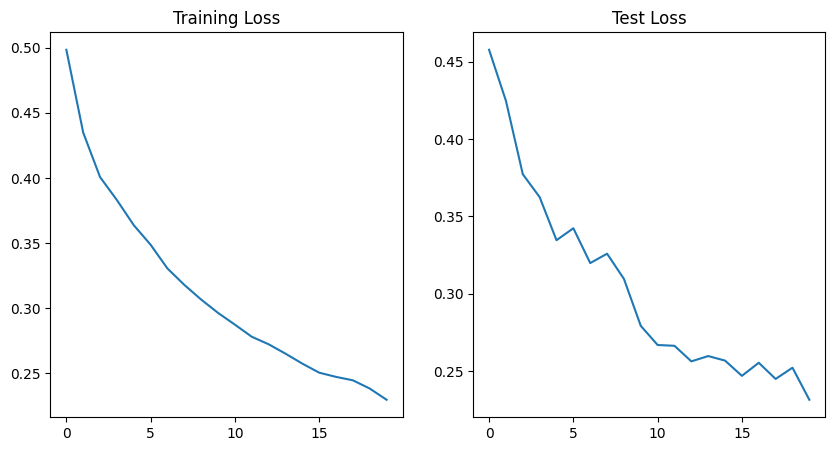

In [11]:
model = UNet(3, 3)
model = model.to('cuda')
summary(model, input_size=(3, 128, 128))

# Dice Loss
criterion = dice_loss

train_session(model, criterion)

---

## 3. Model Training - Strided Convolution + Transpose + Cross Entropy Loss

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          16,448
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

Train: Loss=0.6431 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.34it/s]


Test set: Average loss: 0.6843
 
Epoch 2


Train: Loss=0.5817 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.32it/s]


Test set: Average loss: 0.6689
 
Epoch 3


Train: Loss=0.6133 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.23it/s]


Test set: Average loss: 0.6891
 
Epoch 4


Train: Loss=0.5215 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.26it/s]


Test set: Average loss: 0.6424
 
Epoch 5


Train: Loss=0.5351 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.30it/s]


Test set: Average loss: 0.6415
 
Epoch 6


Train: Loss=0.5124 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.32it/s]


Test set: Average loss: 0.5891
 
Epoch 7


Train: Loss=0.4789 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.27it/s]


Test set: Average loss: 0.5333
 
Epoch 8


Train: Loss=0.4660 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.22it/s]


Test set: Average loss: 0.5289
 
Epoch 9


Train: Loss=0.4565 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.30it/s]


Test set: Average loss: 0.5365
 
Epoch 10


Train: Loss=0.4481 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.33it/s]


Test set: Average loss: 0.4980
 
Epoch 11


Train: Loss=0.4292 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.28it/s]


Test set: Average loss: 0.4690
 
Epoch 12


Train: Loss=0.4057 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.20it/s]


Test set: Average loss: 0.4600
 
Epoch 13


Train: Loss=0.3851 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.21it/s]


Test set: Average loss: 0.4645
 
Epoch 14


Train: Loss=0.3865 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.31it/s]


Test set: Average loss: 0.4412
 
Epoch 15


Train: Loss=0.3595 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.30it/s]


Test set: Average loss: 0.4229
 
Epoch 16


Train: Loss=0.3414 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.25it/s]


Test set: Average loss: 0.4111
 
Epoch 17


Train: Loss=0.3332 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.18it/s]


Test set: Average loss: 0.3967
 
Epoch 18


Train: Loss=0.3146 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.32it/s]


Test set: Average loss: 0.3864
 
Epoch 19


Train: Loss=0.3044 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.31it/s]


Test set: Average loss: 0.3858
 
Epoch 20


Train: Loss=0.3107 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.29it/s]


Test set: Average loss: 0.3843


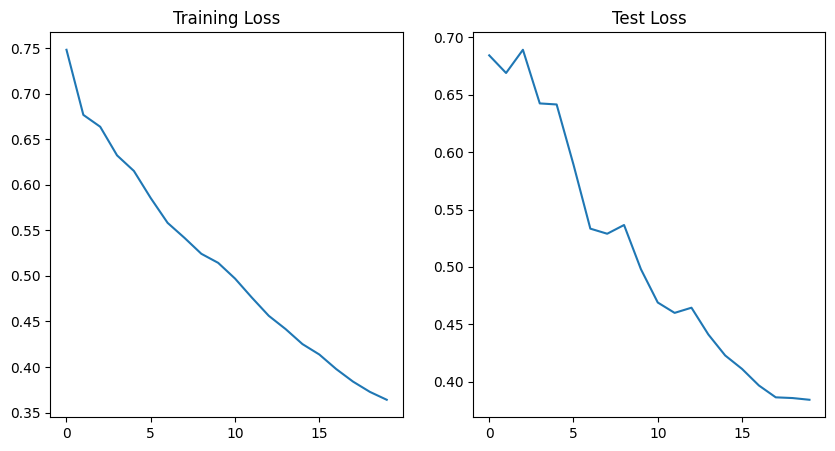

In [12]:
model = UNet(3, 3, max_pool=False)
model = model.to('cuda')
summary(model, input_size=(3, 128, 128))

# CE Loss
criterion = nn.CrossEntropyLoss()

train_session(model, criterion)

---

## 4. Model Training - Strided Convolution + Upsampling + Dice Loss

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          16,448
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

Train: Loss=0.4750 Batch_id=229: 100%|██████████| 230/230 [00:45<00:00,  5.01it/s]


Test set: Average loss: 0.5044
 
Epoch 2


Train: Loss=0.4419 Batch_id=229: 100%|██████████| 230/230 [00:45<00:00,  5.07it/s]


Test set: Average loss: 0.4964
 
Epoch 3


Train: Loss=0.3580 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.99it/s]


Test set: Average loss: 0.4243
 
Epoch 4


Train: Loss=0.4270 Batch_id=229: 100%|██████████| 230/230 [00:45<00:00,  5.05it/s]


Test set: Average loss: 0.4081
 
Epoch 5


Train: Loss=0.3887 Batch_id=229: 100%|██████████| 230/230 [00:45<00:00,  5.02it/s]


Test set: Average loss: 0.3716
 
Epoch 6


Train: Loss=0.3770 Batch_id=229: 100%|██████████| 230/230 [00:45<00:00,  5.06it/s]


Test set: Average loss: 0.3455
 
Epoch 7


Train: Loss=0.3572 Batch_id=229: 100%|██████████| 230/230 [00:45<00:00,  5.04it/s]


Test set: Average loss: 0.3415
 
Epoch 8


Train: Loss=0.3482 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.97it/s]


Test set: Average loss: 0.3153
 
Epoch 9


Train: Loss=0.3408 Batch_id=229: 100%|██████████| 230/230 [00:45<00:00,  5.06it/s]


Test set: Average loss: 0.3058
 
Epoch 10


Train: Loss=0.3313 Batch_id=229: 100%|██████████| 230/230 [00:45<00:00,  5.00it/s]


Test set: Average loss: 0.3002
 
Epoch 11


Train: Loss=0.2678 Batch_id=229: 100%|██████████| 230/230 [00:45<00:00,  5.05it/s]


Test set: Average loss: 0.2887
 
Epoch 12


Train: Loss=0.2832 Batch_id=229: 100%|██████████| 230/230 [00:45<00:00,  5.04it/s]


Test set: Average loss: 0.2833
 
Epoch 13


Train: Loss=0.2644 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.99it/s]


Test set: Average loss: 0.3209
 
Epoch 14


Train: Loss=0.2959 Batch_id=229: 100%|██████████| 230/230 [00:45<00:00,  5.08it/s]


Test set: Average loss: 0.2778
 
Epoch 15


Train: Loss=0.2439 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.95it/s]


Test set: Average loss: 0.2734
 
Epoch 16


Train: Loss=0.2196 Batch_id=229: 100%|██████████| 230/230 [00:45<00:00,  5.05it/s]


Test set: Average loss: 0.2663
 
Epoch 17


Train: Loss=0.2490 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  5.00it/s]


Test set: Average loss: 0.2699
 
Epoch 18


Train: Loss=0.2388 Batch_id=229: 100%|██████████| 230/230 [00:45<00:00,  5.05it/s]


Test set: Average loss: 0.2513
 
Epoch 19


Train: Loss=0.2138 Batch_id=229: 100%|██████████| 230/230 [00:45<00:00,  5.04it/s]


Test set: Average loss: 0.2701
 
Epoch 20


Train: Loss=0.2029 Batch_id=229: 100%|██████████| 230/230 [00:45<00:00,  5.03it/s]


Test set: Average loss: 0.2582


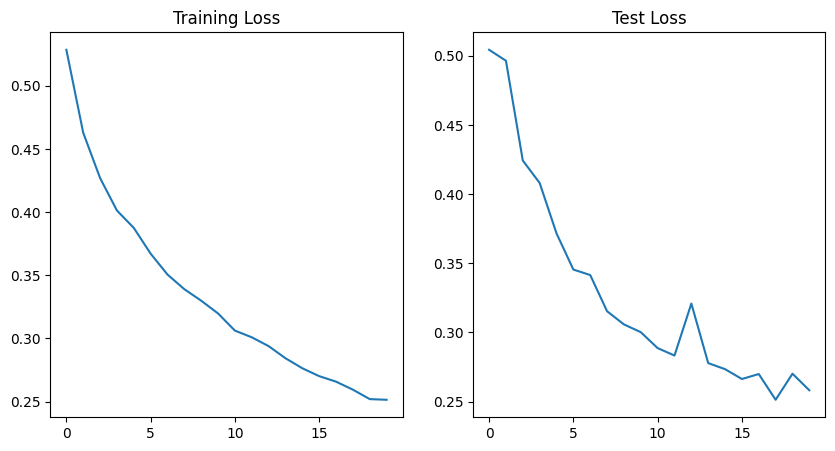

In [13]:
model = UNet(3, 3, max_pool=False, transpose=False)
model = model.to('cuda')
summary(model, input_size=(3, 128, 128))

# Dice Loss
criterion = dice_loss

train_session(model, criterion)

---

## Model Predictions

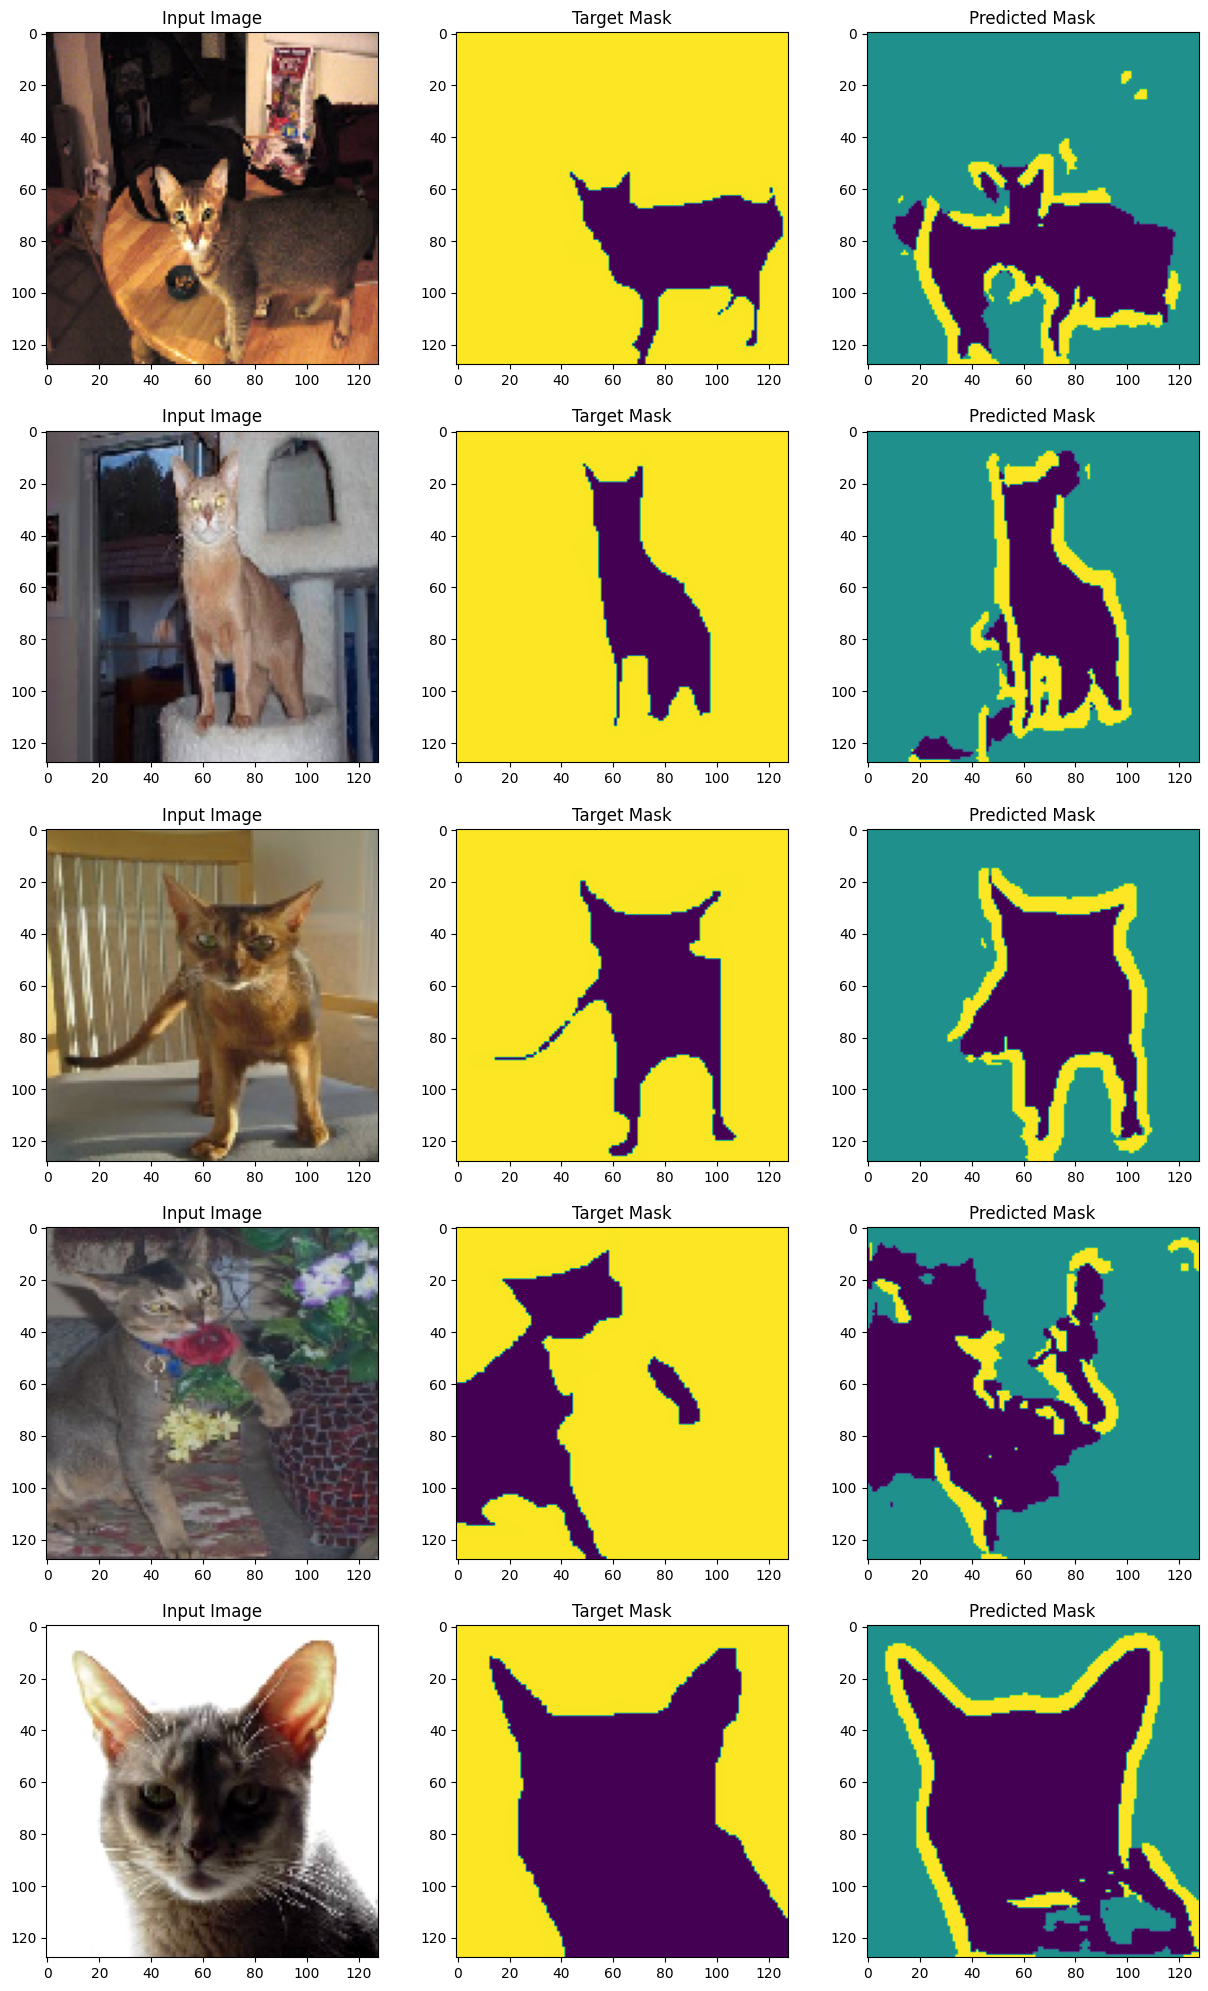

In [14]:
display_output(model, test_loader)

## Save the Model

In [15]:
torch.save(model.state_dict(), 'UNet.pth')